In [1]:
%reload_ext autoreload
%autoreload 2

from lib.basis import construct_rotation_matrix
from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MultiBasisDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506081653_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506081653_0


In [2]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    @staticmethod
    def rotated_log_prob(rotation_weights, free_energy_lambda, free_energy_mu):
        # weights are stable known values and the phase part is bounded by +-1. We do log_sum_exp only the real part

        computational_log_magnitudes = -0.5 * free_energy_lambda
        computational_phases = -0.5j * free_energy_mu

        max_computational_log_magnitude = jnp.max(computational_log_magnitudes)

        scaled_computational_amplitudes = jnp.exp(computational_log_magnitudes - max_computational_log_magnitude + computational_phases)

        scaled_measurement_amplitude = jnp.vdot(rotation_weights, scaled_computational_amplitudes)

        log_measurement_amplitude = max_computational_log_magnitude + jnp.log(jnp.abs(scaled_measurement_amplitude) + 1e-30)
        return 2 * log_measurement_amplitude


    def __call__(self, measurement_tuple: Tuple) -> jnp.ndarray:
        measurement, basis = measurement_tuple

        local_indices = jnp.array(jnp.nonzero(basis != 0, size=2, fill_value=-1)[0])

        # get the free energies for all computational basis vectors to construct the full state vector
        local_rotation_matrix = construct_rotation_matrix(basis[local_indices])

        # for outcome 00 we pick first row, for 01 second row, etc.
        local_rotation_weights = local_rotation_matrix[bitstring_to_int(measurement[local_indices])]

        # amplitudes mismatching with our Z measurements are 0. There are only 4 remaining amplitudes with the local variations
        local_measurement_combos = jnp.array([[0,0], [0,1], [1,0], [1,1]], dtype=measurement.dtype)
        local_computational_basis_vectors = jnp.tile(measurement, (4, 1)).at[:, local_indices].set(local_measurement_combos)  # (4, n)

        local_free_energy_lambda = self._free_energy_amp(local_computational_basis_vectors)
        local_free_energy_mu = self._free_energy_pha(local_computational_basis_vectors)

        rotated_log_prob = self.rotated_log_prob(local_rotation_weights, local_free_energy_lambda, local_free_energy_mu)
        return rotated_log_prob

In [3]:
def full_basis_loss(
        params: PyTree,
        apply_fn: Callable,
        amp_vars: Dict[str, jnp.ndarray],
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:

    basis_measurements, bases = data_tuple

    single_sample_loss = lambda m, b: apply_fn({'params': params, 'amp': amp_vars}, (m, b))
    single_basis_loss = lambda ms, b: jnp.mean(jax.vmap(lambda m: single_sample_loss(m, b))(ms))

    return -jnp.sum(jax.vmap(lambda ms, b: single_basis_loss(ms, b))(basis_measurements, bases))


@jax.jit
def train_step_natural(
        state: "TrainState",
        amp_vars: dict,
        data_tuple: tuple,
        eps: float = 1e-6) -> tuple:

    loss = full_basis_loss(state.params, state.apply_fn, amp_vars, data_tuple)

    base_measurements, bases = data_tuple
    num_bases, batch_size, num_qubits = base_measurements.shape
    num_samples = num_bases * batch_size

    measurements_flat = base_measurements.reshape((num_samples, num_qubits))
    bases_flat = bases.repeat(batch_size, axis=0)

    single_sample_loss_fn = lambda params, b, m: state.apply_fn({'params': state.params, 'amp': amp_vars}, (m, b))
    single_sample_grad_fn = lambda params, b, m: jax.grad(single_sample_loss_fn)(params, b, m)

    grads_flat_pytree = jax.vmap(lambda m, b: single_sample_grad_fn(state.params, b, m))(measurements_flat, bases_flat)
    mean_grad_pytree = jax.tree.map(lambda g: jnp.mean(g, axis=0), grads_flat_pytree)

    # once we have our gradients we ravel the PyTree to get a flat parameter dimension
    mean_grad, unravel_fn = ravel_pytree(mean_grad_pytree)
    grads_flat   = jax.vmap(lambda g: ravel_pytree(g)[0])(grads_flat_pytree)

    # calculate the full fisher matrix as outer
    fisher_matrix = (grads_flat.T @ grads_flat) / grads_flat.shape[0]
    fisher_matrix += eps * jnp.eye(fisher_matrix.shape[0], dtype=fisher_matrix.dtype) # regularize diagonal

    # solving the linear system fisher_matrix @ nat_grad_flat = mean_grad is more stable than inverting the matrix
    nat_grad_flat = jnp.linalg.solve(fisher_matrix, mean_grad)

    # implement the learning rate normalization form the paper
    fisher_matrix_norm = jnp.dot(mean_grad, jnp.dot(fisher_matrix, mean_grad))
    lr_magnitude = 1 / jnp.sqrt(fisher_matrix_norm + eps)
    nat_grad_flat *= lr_magnitude

    # the optimizer again needs our PyTree structure to apply the gradients
    nat_grad_pytree = unravel_fn(nat_grad_flat)
    new_state = state.apply_gradients(grads=nat_grad_pytree)
    return new_state, loss


def train_rbm_natural(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int,
        eps: float = 1e-8) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:
            state, loss = train_step_natural(state, amp_vars, data_tuple, eps=eps)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [4]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [5]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [6]:
batch_size    = 6400
visible_units = 8
hidden_units  = 16
num_epochs    = 200
lr       = 1e-2
eps = 1e-2

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_meas  = jnp.zeros((visible_units,), dtype=jnp.float32)
dummy_basis = jnp.zeros((visible_units,), dtype=jnp.int8)

vars_pha = model_pha.init(key, (dummy_meas, dummy_basis))

dummy_optim = optax.sgd(lr)
state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=dummy_optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2}, shuffle=True)

%time state_pha, metrics_pha = train_rbm_natural(state_pha, amp_vars, loader_pha, num_epochs, eps=eps)

Epoch 1/200 │ Loss: -139.3669
Epoch 2/200 │ Loss: -139.3669
Epoch 3/200 │ Loss: -139.3669
Epoch 4/200 │ Loss: -139.3669
Epoch 5/200 │ Loss: -139.3669
Epoch 6/200 │ Loss: -139.3669
Epoch 7/200 │ Loss: -139.3669
Epoch 8/200 │ Loss: -139.3669
Epoch 9/200 │ Loss: -139.3669
Epoch 10/200 │ Loss: -139.3669
Epoch 11/200 │ Loss: -139.3669
Epoch 12/200 │ Loss: -139.3669
Epoch 13/200 │ Loss: -139.3669
Epoch 14/200 │ Loss: -139.3669
Epoch 15/200 │ Loss: -139.3669
Epoch 16/200 │ Loss: -139.3669
Epoch 17/200 │ Loss: -139.3669
Epoch 18/200 │ Loss: -139.3669
Epoch 19/200 │ Loss: -139.3669
Epoch 20/200 │ Loss: -139.3669
Epoch 21/200 │ Loss: -139.3669
Epoch 22/200 │ Loss: -139.3669
Epoch 23/200 │ Loss: -139.3669
Epoch 24/200 │ Loss: -139.3669
Epoch 25/200 │ Loss: -139.3669
Epoch 26/200 │ Loss: -139.3669
Epoch 27/200 │ Loss: -139.3669
Epoch 28/200 │ Loss: -139.3669
Epoch 29/200 │ Loss: -139.3669
Epoch 30/200 │ Loss: -139.3669
Epoch 31/200 │ Loss: -139.3669
Epoch 32/200 │ Loss: -139.3669
Epoch 33/200 │ Lo

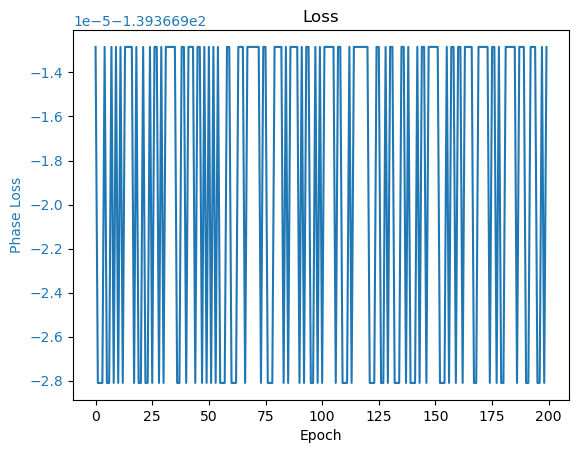

In [7]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [8]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)
one_hot_bitstrings = [''.join('1' if s > 0 else '0' for s in state) for state in one_hot_states]

model_phases_raw = model_pha.apply({"params": state_pha.params, "amp": amp_vars}, one_hot_states, method=model_pha.compute_phase)
model_phases_norm = model_phases_raw - model_phases_raw[-1]
model_phases_wrapped = model_phases_norm % (2 * jnp.pi)

model_phase_tuples = sorted(zip(one_hot_bitstrings, model_phases_raw, model_phases_wrapped), key=lambda x: int(x[0], 2))

for bitstring, phase_raw, phase_wrapped in model_phase_tuples:
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 11.0818 (raw), 0.0000 (wrapped)
00000010: 11.0845 (raw), 0.0027 (wrapped)
00000100: 11.1164 (raw), 0.0347 (wrapped)
00001000: 11.0941 (raw), 0.0123 (wrapped)
00010000: 11.1097 (raw), 0.0279 (wrapped)
00100000: 11.0797 (raw), 6.2811 (wrapped)
01000000: 11.0943 (raw), 0.0126 (wrapped)
10000000: 11.0868 (raw), 0.0050 (wrapped)


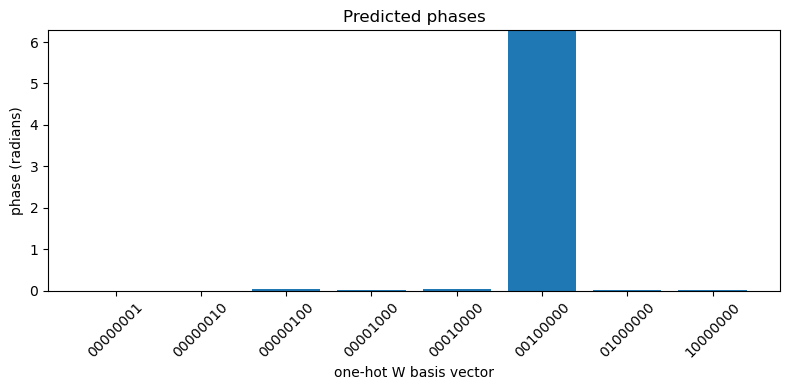

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in model_phase_tuples], [t[2] for t in model_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Predicted phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
w_aug_file_path = Path(data_dir) / f"w_aug_{visible_units}.txt"
w_aug_state_dict = load_state_vector(w_aug_file_path)

phase_offset = np.angle(w_aug_state_dict[one_hot_bitstrings[-1]])

original_phase_tuples = []
for bs in sorted(one_hot_bitstrings, key=lambda x: int(x, 2)):

    amplitude = w_aug_state_dict[bs]
    phase_raw = np.angle(amplitude)  # get raw phase in radians
    phase_norm = phase_raw - phase_offset  # normalize by the last one-hot state
    phase_wrapped = phase_norm % (2 * jnp.pi)

    original_phase_tuples.append((bs, amplitude, phase_raw, phase_wrapped))

for bitstring, amp, phase_raw, phase_wrapped in original_phase_tuples:
    print(f"{bitstring}: {amp:.8f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 0.35348165+0.00712282j (ampl), 0.0201 (raw), 0.0000 (wrapped)
00000010: 0.34222963+0.08876304j (ampl), 0.2538 (raw), 0.2336 (wrapped)
00000100: -0.07679566+0.34511220j (ampl), 1.7898 (raw), 1.7696 (wrapped)
00001000: 0.02867402-0.35238871j (ampl), -1.4896 (raw), 4.7734 (wrapped)
00010000: 0.01964585+0.35300714j (ampl), 1.5152 (raw), 1.4951 (wrapped)
00100000: -0.03371835+0.35194188j (ampl), 1.6663 (raw), 1.6462 (wrapped)
01000000: -0.28657940-0.20705615j (ampl), -2.5159 (raw), 3.7471 (wrapped)
10000000: -0.13468251-0.32689542j (ampl), -1.9616 (raw), 4.3014 (wrapped)


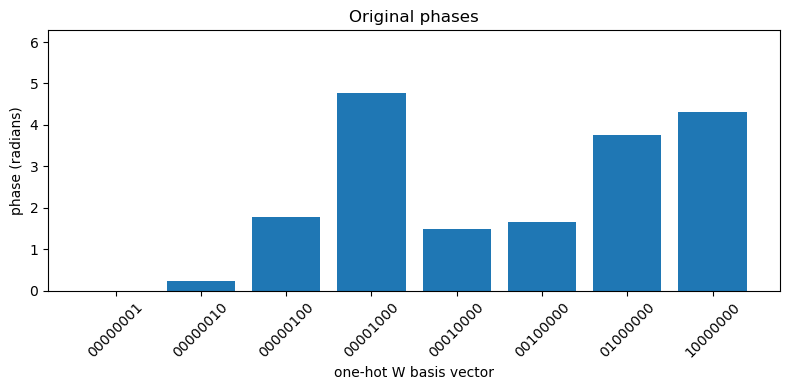

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in original_phase_tuples], [t[3] for t in original_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Original phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()